---
>「ドライバーが車を選ぶんじゃない。車がドライバーを選ぶんだ。人間と機械の間には、神秘的な絆があるんだ」 \
>（ボビー:映画トランスフォーマーより）
---

## なぜTransformerが重要なのか

Transformerは、自然言語処理に適する方法として見出されたが、これにはどのような経緯があったのか、簡単に説明する


### 自然言語処理はなぜ困難なのか

まず、言語データは画像データと本質的に扱い方が異なる

- 画像データは画素の集まりであり、CNNでは画像全体から近隣の画素の特徴をとらえて処理する
- 言語データは単語を逐次的に聞いて処理する
  - つまり、過去の単語の入力情報を保持し、文脈を理解する必要がある
  - 例えば、「まいった」だけではわからないが、「失敗してまいった」「神社にまいった」となればわかる

言語データの性質から、逐次的に処理する仕組みが必要
- 従来は、この性質から、RNN (Recurrent Neural Network)やLSTM (Long short-term memory)などが利用されてきた
  - 内部状態として過去の状態を記録することができるため
- 一方で、RNN、LSTMは学習時間が長く大きなモデルを構築するのが困難であった
  - 文章の単語を1stepに1単語ずつモデルに投入するため、バッチにより並列的に大量に処理できるCNNと異なり時間がかかる

処理速度を稼ぐため、CNNやFCを利用する試みもなされた
- 処理速度は向上するが、やはり文章の離れた単語間の関係性を考慮できないため、精度の向上が困難であった
  - 主語と述語は文章の最初と最後であり、この主述関係を理解しようとするとCNNや勾配消失の大きいRNNでは困難であることは容易に想像できる

RNNとは全く異なるアプローチ
- TransformerではEncoderおよびDecoderのいずれにもRNNのような再帰構造をもたず、Attentionが利用されている
- その優れた特徴から、自然言語処理以外の分野でも利用が進む

# Transformer
- 2017年に導入されたディープラーニングモデルの一種
  - 主に自然言語処理で利用されている
- RNNと同様自然言語などの時系列データ処理向けに設計されているが、再帰や畳み込みは利用していない
- Attention層のみで構築されている(後述)
- 翻訳やテキスト要約などの各種タスクに利用可能
- 並列化が容易で訓練時間を削減できる
- 「Attention is All You Need」という論文で著名になった
- 機械翻訳タスクにおいてRNNを用いたモデルよりも精度がよく、訓練コストが小さいことから革命的であり、NLPではRNNに印籠を渡し現在の主流の方法である
  - この後登場するBERT、ELECTRA、GPTなどすべてTransformerを基本としている



### Transformerの構造

<img src="http://class.west.sd.keio.ac.jp/dataai/text/transformer.png" width=500>

Seq2Seq同様EncoderとDecoderで構成



#### Encoderの構造

文章から意味ベクトルを抽出する

1. Embedding層により入力文章をベクトルに圧縮、つまり分散表現に変換する
1. Positional Encoder層で文章内のどこにあるかという位置情報を加える
1. Multi-Head Attention層
  - 最も本質的かつ重要な層
1. normalization(正規化)によりデータの偏りを削減する
  - batch normalizationではなくlayer normalizationが行なわれる
  - Add & Normで学習速度を高めている
1. Feed Forward層
  - 2層で活性化関数はReLU

以上のMulti-Head AttentionからFeed Forward、Add&Normまでを1セットとして、実際のモデルでは例えば6セット繰り返される
  - 出力されたベクトルはDecoderに渡される
  - 特にPositionwise fully connected feed-forward networkと呼ばれる

n文字入ると、Multi-Head Attentionはn入力について以外はn並列で処理している

以上で、Encoderが構成される

なお、文字は512次元でベクトル化される

#### Decoderの構造

抽出された意味ベクトルから文章を生成する

1. Embedding層により入力文章をベクトルに圧縮(分散表現を獲得)
1. Positional Encoder層で位置情報を追加
1. Masked Multi-Head Attention層、先ほどと同様であるがAttention内のsoftmax関数を通す直前の値にマスキングが適用されている
  - 特定のkeyに対して、Attention weightを0にすることで入力した単語の先読みによる「カンニング」を防ぐ
  - 入力に予測すべき結果が入らないようにする
1. normalization（正規化）などで先ほどと同様
1. Multi-Head Attention層（Encoderの出力を入力として使用）
1. normalization（正規化）など
1. Positionwise fully connected feed-forward network(先ほどと同じ)
1. normalization（正規化）など
- 例えば、以上を6回繰り返す


### Transformerの構成要素

- Attention
  -「文章中のどの単語に注目すればよいかを表すスコア」のこと
  - Query、Key、Valueの3つのベクトルで求める
    - Query: Inputのうち「検索をかけたいもの」
    - Key: 検索対象とQueryの近さ、どれだけ似ているかを測る
    - Value: Keyに基づき、適切なValueを出力する
  - Self-Attention
    - 下図でInputとMemoryが同一のAttention
      - 文法の構造や、単語同士の関係性などを獲得するのに使用される
  - SourceTarget-Attention
    - 下図でInputとMemoryが異なるAttention
      - TransformerではDecoderで使用される
  - Multi-Head Attention
    - Attentionを複数並列して並べたもの(後述)
  - Masked Multi-Head Attention
    - Multi-Head Attentionにマスクをつけたもの
    - 特定の key に対してAttention weight を0にする
    - TransformerではDecoderで使われる
    - 入力した単語が先読みを防ぐために 情報をマスクで遮断する、言わば「カンニング」を防ぐ
  - Attentionは可視化できる
    - すでに示したが、attentionは可視化でき、どの単語に注目しているかを知ることができる
- Position-wise Fully-connected Feedforward Network
  - 2層からなる全結合ニューラルネットワーク
  - 単語の位置ごとに個別の順伝播ネットワークとなる
    - これにより他単語との影響関係を排除することができる
  - パラメータは全てのネットワークで共通
$FNN(x) = ReLU(xW_1+b_1)\cdot W_2+b_2$
- Positional Encoding ($PE$)
  - 「単語の位置」の情報をベクトルに加える
    - 本当に加えるだけで次元を増やさない
  - $pos$は位置を表し、$2i$および$2i+1$はEmbeddingの何番目の次元か、$d_{model}$が次元数を示す
偶数番目：$PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}})$
奇数番目：$ PE_{(pos,2i+1)}=cos(pos/10000^{2i/d_{model}})$

<img src="http://class.west.sd.keio.ac.jp/dataai/text/attention2.png" width=800>

- 丸角(緑)がベクトル(テンソル)、四角角(青)が処理を表す
- **InputとMemoryはそれぞれ異なる埋め込みベクトルを表し、例えば2つの異なる文章を表す**
- Inputについて全結合層で各単語のQueryを作成する
- Memoryについても同様に全結合層でKeyを作成しQueryとの内積をとって関連度合い見る
  - 同じ向きを向いていれば掛け算となる
  - 垂直である、つまり関連しなければ0
  - この値を関連度(logit)とする
- logitにSoftmaxを適用して0から1の間に調整して出力、この結果が Attention weightとなる
  - メモリのどの単語に注意を払うかの重みづけ
  - QueryとKeyの関連が大きいとAttention weightが大きくなる
    - 正しくMemoryの単語に注意を向けるように,keyが正しくAttentionに向けられるように学習される
- Memoryから全結合層を経て、Memoryの各単語に対する埋め込みベクトルであるValueを算出する
  - ValueとAttention weightとの内積を求める
    - Attention weightに従ってValueを選択することを意味する
- 最後に全結合層を挟んで出力を得る




### InputとMemory

<img src="http://class.west.sd.keio.ac.jp/dataai/text/input-memory.png" width=600>

各文章は分かち書きされIDで表現された後、Embeddingにより埋め込みベクトルに変換される

### Attention Weightの算出

<img src="http://class.west.sd.keio.ac.jp/dataai/text/attention-weight.png" width=600>

QueryとKeyの内積を算出してInputとMemoryの各単語の関連度であるlogitを算出、Softmaxを用いてAttention weightとする
- Memoryのどの単語に注意を払うかの重み付け

例えば、Inputのスポーツという単語に対して、Memoryの「野球」 「が」 「得意」の各単語について正しく注意を向けるように学習する
- ここでは野球が高い値になるようになる

### valueとの内積

<img src="http://class.west.sd.keio.ac.jp/dataai/text/value-naiseki.png" width=600>

この内積は、value、ここでは「野球」「が」「得意」の各単語のValueとAttention weightを掛け合わせて総和を計算することになる

最も注目するべきvalueの値が算出されているといえるが、他の単語との関連性も考慮した値となっている

### Multi-Head Attention

Multi-Head Attentionの構成要素は次のような図で表現されるが、これはこれまでの説明で理解できるであろう

<img src="http://class.west.sd.keio.ac.jp/dataai/text/mhattention.jpg" width=200>

ここで、Transformerでも用いられるMulti-Head Attentionでは、この図のように$Q$、$K$、$V$に同じ入力$X$を与えている

<img src="http://class.west.sd.keio.ac.jp/dataai/text/transformer-mha.png" width=200>

- 実際にTransformerの構造図を見るとわかる
- Queryつまり入力に$X$を与えるのは理解できるが、$K$にも$V$にも入れるのは、意味不明に感じるであろう

だが、先に示したMulti-Head Attentionの説明の通り、再掲すると、

>数式では次のように表すことができる
>
>$$MHA(Q, K, V) = concat(head_i)W^O$$
>
>ここで
>
>$$head_i=Attention(QW^Q_i, KW^K_i, VW^V_i)$$
>
>である
>
>Q, K, Wに対して、$W^Q_i$, $W^K_i$, $W^V_i$という重み行列を掛けて、Attentionを求め、さらに$W^O$という重み行列を掛けて、行列を1次元ベクトルに変換するといった動作となる
>
>例えば、Transformerでは、$W^Q_i$, $W^K_i$, $W^V_i$は一般に8次元であり、入力列を8個の列に重みを掛けて拡張し、それに対してAttentionを求め、さらに一列にするという動作である

つまり、$W^Q_i$, $W^K_i$, $W^V_i$という重み行列を掛けており、この重み行列で表されるアファイン変換によりXをねじって曲げたベクトルとの比較を行っていると考えることができる
- Transformerでは$W^Q_i$, $W^K_i$, $W^V_i$という重み行列を掛けることで、大きさが$1/8$になった8個のベクトルに変換され、それぞれで計算して、最後にconcatで1つに戻すといった処理が行われており、8個に分割したそれぞれについて、アファイン変換を行い、それらの類似度に合った値を生成して、最後に結合するといった処理を行っている
- Xについて、8分割したどの部分をどのように変換したベクトルと、どの部分をどのように変換したベクトルがどの程度一致したら、どの部分で表されるどのような値を出力しなさい、といった表現になる

## DecoderにおけるAttention



次のような入力形態となっている

<img src="http://class.west.sd.keio.ac.jp/dataai/text/transformer-mha-dec.png" width=200>

$V$と$K$はEncoderからの入力で、$Q$はDecoderの入力からきている

翻訳では、$V$と$K$に元の言語の文章A、$Q$に翻訳先の言語の文章Bを入力して、AとBの類似度を得る、さらにAから作った値を返す、という意味になる

## Positional Encoding

Postional Encoding層は、系列データ内の各要素に、要素のデータ内における位置情報を付与する
- 文章の場合、Positional Encodingによって、各単語ベクトルに、その単語が文章内で何番目に登場するかという情報を付与する

次の式で算出した値を固定値として、入力に加算する

$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})$

$PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}})$

このPositional Encodingの値を図示すると次のようになる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/pos_encoding.png" width=400>


## Transformerにおいて交換されるデータの形

何が入ってきて何が出ていくのか

Transformerでは、常に$単語数 \times 埋め込み次元数$で与えられるテンソルが各ブロック間で受け渡される

例外もあり、
- embedding層の前では各行が語彙数次元のone-hotベクトルとなっている
- 最後の出力では語彙数次元の確率分布ベクトルとなっている

であるが、Transformerブロック内では、$単語数 \times 埋め込み次元数$の行列の各行に各種変換を施すという処理が繰り返される
- この処理は各行独立という意味ではなく、例えばSelf-Attentionでは行と単語の関係に注目している

また、Transformerでは、RNNの隠れ状態のような文脈ベクトル、つまり文意を1つのベクトルで表した潜在空間表現の類を明確に生成していない


## Transformerの出力

Transformer において各層から得られる出力ベクトルは、しばしば「embedding」と呼ばれることがあるが、厳密には Transformer の出力は文字（あるいはトークン）そのものの embedding ではない。この点を正確に理解することは、Transformer の動作原理や表現能力を理解する上で極めて重要




### まず「embedding」とは何か

一般に embedding とは、離散的な記号（文字・単語・トークンなど）をそれ自体の意味を表す連続値ベクトルに写像したものを指す

embedding層がpytorchにはあるが、内容はハッシュテーブルであり、ハッシュの各エントリを学習するように構成される
- クラス分類などワンホットかつ大量にあるときに計算コストを削減する手法として利用される
- なお、FC層を使ったembeddingもあるが、これは一般的な数値入力に対して実施する

Transformer における 入力 embedding は典型例であり、各トークンIDに対して学習可能な固定のベクトルが割り当てられる

この embedding は、文脈に依存せず、同じトークンであれば、どこに現れても同じベクトルという性質を持つ

### Transformerの出力は何を表しているのか

Transformer の各層の出力は、次の処理を経て得られる
- 入力 embedding + 位置情報
- Self-Attention による情報混合
- Feed Forward Network による非線形変換
- 残差接続・正規化

ここで重要なのは、Self-Attention の存在である

- Self-Attention により、各位置のベクトルは
- 「そのトークン自身」＋「文中の他のトークンから集約された情報」

の混合表現になることから、Transformer の出力ベクトルは、「この位置にあるトークンが、この文脈の中で果たしている役割」を表す 文脈依存表現（contextualized representation） である

### 同じ文字でも出力が変わるという決定的な違い

ここが embedding と Transformer 出力の本質的な違い

- 入力 embeddingは同じトークンなら常に同じベクトル
- Transformer の出力は同じトークンでも、文脈が違えば全く異なるベクトル

つまり、トークンそのものの embeddingではなく文脈を反映した状態表現である

### 実際はどうなっているのか



以下は「1024次元・語彙1万」という具体条件で、“出力＝埋め込み”の誤解がどこで生まれるかを、形状（テンソルの次元）と計算で潰す説明です。数式は最小限ですが、計算の流れは具体的に書きます。

#### 前提（この例で固定する設定）

- 語彙数（トークン種類数）: $V=10000$
- 埋め込み次元: $d_{model}=1024$
- 入力系列長: L=128
- 1層の self-attention（multi-head でも同じ)
- バッチは1として説明（バッチ次元は省略）

###「入力埋め込み」は $10000\times1024$ の表

学習パラメータとして

$$E \in \mathbb{R}^{V\times d_{model}}=\mathbb{R}^{10000\times 1024}$$

がある

トークンID $t \in \{1,…,10000\}$ に対し、入力埋め込みは

$$x=E[t] \in \mathbb{R}^{1024}$$

つまり語彙表の中から一つとってくるだけである

系列長 $L$ の入力なら、

$$X \in \mathbb{R}^{L\times 1024}$$

が入力となる

また、位置埋め込み等を加算しても形状は同じである

#### Self-Attentionの内部計算（形状つき）

Transformer層は、入力 $X$ から次を作る

(a) Q, K, V の線形変換

学習パラメータ
$$W_Q, W_K, W_V \in \mathbb{R}^{1024\times 1024}$$
として、
$$Q=XW_Q, K=XW_K, V=XW_V$$
を求め、形状はすべて、
$$Q, K, V \in \mathbb{R}^{L\times 1024}$$
である

つまり、この時点で入力埋め込みの値ではなくなる
- $W_Q$などにより、埋め込み空間が別の基底に写され、混ざる


(b) 注意（attention）重み

スコア行列
$$S=\frac{QK^\mathsf{T}}{1024}$$
であり、その形状は
$$S \in \mathbb{R}^{L\times L}$$
である

softmax を各行にかけると、
$$ A = softmax(S) \in \mathbb{R}^{L\times L}$$
となる

(c) 出力（文脈混合）

$$Y =AV$$
であり、形状は
$$ Y \in \mathbb{R}^{L\times 1024}$$

この $Y$ の各行 $y_i \in \mathbb{R}^{1024}$は
	​
$$ y_i = \sum^L_{j=1} A_{ij}v_j$$

つまり、位置$i$の出力は、系列中の全位置の$v_j$の重み付き和であり、トークン$t_i$の埋め込み$E[t_i]$ ではない

同じトークンでも周囲が違えば$A_{ij}$ が変わるので、出力は変わる

#### 出力の形状

出力は、$L \times 1024$のベクトルであり、各要素は入力の文字埋め込みではない

次トークン予測をする言語モデルでは、最後に語彙へ写像する必要があるため、これを語彙に戻さなければならない

出力$y$の$i$番目の要素を$y_i$とし、語彙$W_{out} \in \mathbb{R}^{1024 \times 10000}$があった時、

なお、出力の単語埋め込み$W_{out}$は、入力の単語埋め込み$W_{in}$と一般的に同じであるが、違ってもかまわない

言語モデルにおいて、softmax をかける直前の、生のスコア（未正規化対数尤度）、つまりlogitsは、

$$ logits_i = y_iW_{out}+b$$

として求まり、その形状は、

$$logits \in \mathbb{R}^{L\times 10000}$$
となる

logitsは確率ではなく、大小関係と差だけが意味を持つ量である

これに、softmaxをかけて確率分布として、選択するべき単語の確率を得ることができる

### 学習時と推論時の違い

Transformer 言語モデルでは、 **学習時（training）と推論時（inference / generation）** で、
同じモデル・同じ計算グラフを使いながらも、出力の使い方が根本的に異なるので注意が必要である

- 学習では「全部の出力」を利用
- 推論では「一番右（最後）」のみ利用




#### 学習時：全ての位置の出力を同時に使う（並列）

言語モデル学習の典型は **次トークン予測** である

$$
(x_1, x_2, \dots, x_L)
$$

に対して、正解（教師）を
$$
(x_2, x_3, \dots, x_{L+1})
$$

として学習

位置 $i$ の出力 $y_i$ は「次トークン $x_{i+1}$」を予測するために利用する

学習時は **正解系列が全文分わかっている** ため、位置 $i=1\dots L$ すべてについて同時に損失を計算できる


典型的な損失（平均）：
$$
\mathcal{L}
= \frac{1}{L}
\sum_{i=1}^{L}
\mathrm{CrossEntropyLoss}(\text{logits}_i,\; x_{i+1})
$$

この方式は
- GPUで **並列化** できる
- 収束が速い（teacher forcing）
- 学習が安定しやすい  
という利点がある



#### causal mask（未来を見ないための必須条件）
自己回帰モデルでは「未来の情報を参照してはいけない」ため、Self-Attention では **causal mask** を利用する

- 位置 $i$ は $1\dots i$ までしか attend できない
- $i+1$ 以降はマスクされる

このため、学習時に「全位置の損失を同時に計算していても」、
各位置の予測は **未来を見ずに** 行われる

### 推論時：最右端（最後）の出力だけを使う（逐次生成）

推論（生成）では、次に来るトークンは未知であるため、次の処理を繰り返す

1. 現在の系列 $(x_1,\dots,x_t)$ を入力  
1. forward で $\text{logits}\in\mathbb{R}^{t\times V}$ を得る  
1. **最後の位置**の logits $\text{logits}_t$ から次トークン $x_{t+1}$ を選ぶ（argmax / sampling）  
1. それを系列に追加して繰り返す

このとき意味を持つのは常に **最右端**の出力のみ

学習は本質的に
$$
p(x_{i+1}\mid x_{\le i})
$$
を各位置で学ぶように設計されます。よって推論時には
$$
p(x_{t+1}\mid x_{\le t})
$$
が欲しいので、位置 $t$ の出力（最右端）だけを使えば十分である

過去の位置 $1\dots t-1$ の logits は「過去の次トークン」を予測するためのもので、  
現在の次トークン生成には不要となる



### 学習で使われるロス関数：Cross-Entropy（最大尤度）

各位置 $i$ での正解トークンを $t^*=x_{i+1}$ とすると

$$
\mathrm{CE}_i = -\log p(t^*\mid x_{\le i})
$$

logits（softmax前）で書くと

$$
\mathrm{CE}_i =
-\text{logits}_i[t^*]
+ \log\sum_{t'} e^{\text{logits}_i[t']}
$$

実装では数値安定性のため、`softmax` を明示せず logits を直接入力に取る loss（例：PyTorchの `CrossEntropyLoss`）を使うのが一般的である

なお、言語モデル評価でよく使う perplexity は、平均 cross-entropy を指数化した値であり（対数底や単位に注意）、概念的にはcross-entropy が小さいほど perplexity も小さい（良いモデル）といえる



### 学習時に特別にケアすべきこと
#### Teacher forcing と exposure bias

学習では、モデル出力ではなく **正解トークンを次入力に使う（teacher forcing）** のが基本
- これにより学習は安定しますが、推論時（モデル自身の出力を入力に回す）とのギャップが生じることがあり、これを **exposure bias** と呼ぶ
- 対策例として scheduled sampling などがありますが、設計・評価が必要となる

#### Padding と loss mask（必須）
バッチ学習では系列長が揃わないため padding を入れます。  
このとき
- padding トークンに対しては損失を **計算しない（無視する）** (必須)
- これを行わない場合、モデルは「paddingを当てる」ことを学習し、学習が壊れる

#### ラベルスムージング（場合によって有効）
正解を one-hot（確率1）で固定せず、少量の確率質量を他クラスにも配ることで、
- 過信（過度な確率集中）を抑える
- 汎化性能が改善する  
場合がある

ただし、タスクや評価指標によっては逆効果もあるため検証が必要

#### 温度（temperature）は通常「推論時」に利用する

温度 $T$ は softmax に入る logits のスケール因子：

$$
p(t) \propto \exp(\text{logits}[t]/T)
$$

推論時には多様性と破綻のバランス調整に有効であるが、
学習時に温度を入れると「学習目標の分布」が変わるため、原則として $T=1$ で学習する

例外として、知識蒸留（distillation）では教師分布を平坦化する目的で $T>1$ を学習中に用いることがある



# Softmax・logitsと温度（temperature）

Transformer/言語モデルでよく出てくる **logits → softmax → 確率** の流れに対して、  **温度（temperature, $T$）がどこに入り、何を変えるのか**を確認する

また、推論時の代表的なサンプリング手法（top-k / top-p）や、attentionのスケーリングとの関係、知識蒸留での温度の意味に触れる

## 前提（記号）
- 語彙数：$V$
- logits：$z \in \mathbb{R}^V$
- softmax：$p = \mathrm{softmax}(z)$


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

## softmax（温度なし）
softmax は logits $z$ から確率 $p$ を作ります：

$$
p_i = \mathrm{softmax}(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{V} e^{z_j}}
$$

- logits は **確率ではなくスコア**（未正規化）
- softmax を通すことで **確率（合計1）** になる


In [ ]:
def softmax(z):
    z = np.asarray(z, dtype=np.float64)
    z = z - np.max(z)  # 数値安定化（定数シフトはsoftmaxを変えない）
    e = np.exp(z)
    return e / np.sum(e)

## 温度付き softmax の定義

温度 $T>0$ を導入すると：

$$
p_i(T) = \frac{e^{z_i/T}}{\sum_{j=1}^{V} e^{z_j/T}}
$$

**温度は logits を $1/T$ 倍する**のと同じ
- $T < 1$：差が強調されて分布が **鋭く**（より確信的）
- $T > 1$：差が圧縮されて分布が **平坦に**（多様性増）

極限：
- $T \to 0$：argmax に近づく（ほぼ一択）
- $T \to \infty$：一様分布に近づく


In [ ]:
def softmax_temperature(z, T):
    z = np.asarray(z, dtype=np.float64)
    if T <= 0:
        raise ValueError("Temperature T must be > 0.")
    return softmax(z / T)

## 数値例
例として logits を

$$
z = [10,\ 9,\ 1]
$$

とします。温度を変えて確率を見比べます。


In [ ]:
z = np.array([10.0, 9.0, 1.0])
for T in [0.5, 1.0, 2.0]:
    p = softmax_temperature(z, T)
    print(f"T={T}: p={p} (sum={p.sum():.6f})")

T=0.5: p=[8.80797066e-01 1.19202920e-01 1.34145215e-08] (sum=1.000000)
T=1.0: p=[7.30992629e-01 2.68917160e-01 9.02116571e-05] (sum=1.000000)
T=2.0: p=[0.61818465 0.37494794 0.00686741] (sum=1.000000)


## 温度が分布の「鋭さ」をどう変えるか
同じ logits に対して、温度 $T$ を連続的に変えると確率がどう動くかをプロット

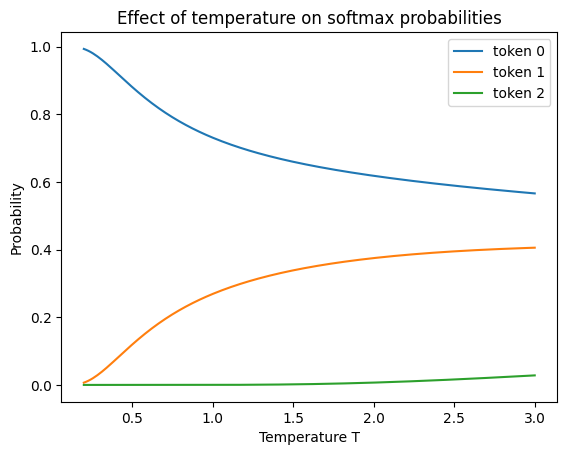

In [ ]:
Ts = np.linspace(0.2, 3.0, 200)
ps = np.array([softmax_temperature(z, T) for T in Ts])  # shape: (len(Ts), V)

plt.figure()
plt.plot(Ts, ps[:, 0], label="token 0")
plt.plot(Ts, ps[:, 1], label="token 1")
plt.plot(Ts, ps[:, 2], label="token 2")
plt.xlabel("Temperature T")
plt.ylabel("Probability")
plt.title("Effect of temperature on softmax probabilities")
plt.legend()
plt.show()

## 「差だけが効く」：温度と logits 差の関係
2クラス（または2つの候補だけ）に注目すると

$$
\frac{p_1}{p_2} = \exp\left(\frac{z_1 - z_2}{T}\right)
$$

つまり温度は **logits の差 $(z_1-z_2)$ の強調率**

この性質により、softmax は定数シフト $z \mapsto z + c$ に不変

In [ ]:
# 確認：zに定数を足してもsoftmaxは不変
c = 123.4
p1 = softmax_temperature(z, 1.0)
p2 = softmax_temperature(z + c, 1.0)
print("max |p1 - p2| =", np.max(np.abs(p1 - p2)))

max |p1 - p2| = 0.0


## 推論（生成）で温度を使う理由
言語モデル生成では、各ステップで語彙分布 $p(t)$ からサンプリングします

- **温度を下げる**：より保守的・決定論的（同じ文脈なら似た出力になりやすい）
- **温度を上げる**：探索的・多様（逸脱も増える）

学習時（cross-entropy）では原則 $T=1$ を用い、推論時に調整するのが一般的

# top-k / top-p（nucleus）サンプリング

温度だけでなく、**候補集合を切る**のが top-k / top-p です。

- **top-k**：上位 k 個の語彙だけ残して再正規化してサンプル
- **top-p（nucleus）**：上位から確率を足して累積が p を超える最小集合だけ残してサンプル

温度は「分布の鋭さ」、top-k/top-p は「探索範囲の制限」という役割分担になる

In [ ]:
def top_k_filter(probs, k):
    probs = np.asarray(probs, dtype=np.float64)
    if k <= 0:
        raise ValueError("k must be >= 1")
    idx = np.argpartition(probs, -k)[-k:]
    mask = np.zeros_like(probs, dtype=bool)
    mask[idx] = True
    filtered = np.where(mask, probs, 0.0)
    s = filtered.sum()
    return filtered / s if s > 0 else filtered

def top_p_filter(probs, p):
    probs = np.asarray(probs, dtype=np.float64)
    if not (0 < p <= 1):
        raise ValueError("p must be in (0, 1].")
    order = np.argsort(probs)[::-1]
    sorted_probs = probs[order]
    cumsum = np.cumsum(sorted_probs)
    keep_n = np.searchsorted(cumsum, p, side="left") + 1
    keep_idx = order[:keep_n]
    filtered = np.zeros_like(probs)
    filtered[keep_idx] = probs[keep_idx]
    s = filtered.sum()
    return filtered / s if s > 0 else filtered

同じ logits から、温度とフィルタで分布がどう変形されるかを見る

In [ ]:
z_demo = np.array([10.0, 9.0, 8.5, 8.0, 1.0, 0.5])
for T in [0.7, 1.0, 1.5]:
    p = softmax_temperature(z_demo, T)
    pk = top_k_filter(p, k=3)
    pp = top_p_filter(p, p=0.9)
    print(f"T={T}")
    print("  softmax :", np.round(p, 4))
    print("  top-k=3 :", np.round(pk, 4), " (nonzero=", np.count_nonzero(pk), ")")
    print("  top-p=0.9:", np.round(pp, 4), " (nonzero=", np.count_nonzero(pp), ")")

T=0.7
  softmax : [0.707  0.1694 0.0829 0.0406 0.     0.    ]
  top-k=3 : [0.7369 0.1766 0.0865 0.     0.     0.    ]  (nonzero= 3 )
  top-p=0.9: [0.7369 0.1766 0.0865 0.     0.     0.    ]  (nonzero= 3 )
T=1.0
  softmax : [5.792e-01 2.131e-01 1.292e-01 7.840e-02 1.000e-04 0.000e+00]
  top-k=3 : [0.6285 0.2312 0.1402 0.     0.     0.    ]  (nonzero= 3 )
  top-p=0.9: [0.6285 0.2312 0.1402 0.     0.     0.    ]  (nonzero= 3 )
T=1.5
  softmax : [0.4653 0.2389 0.1712 0.1227 0.0012 0.0008]
  top-k=3 : [0.5315 0.2729 0.1955 0.     0.     0.    ]  (nonzero= 3 )
  top-p=0.9: [0.4662 0.2394 0.1715 0.1229 0.     0.    ]  (nonzero= 4 )


## 知識蒸留（distillation）における温度
知識蒸留では、教師モデルの出力分布を「柔らかく」して学生モデルに学習させるために  
温度を **学習中**に使うことがあります。

概念的には：
- 教師：$p_T = \mathrm{softmax}(z^{(teacher)}/T)$ を作る（$T>1$ で平坦化）
- 学生：その分布に近づくように KL などで学習

これにより「最大クラス以外の相対関係」も学びやすくなります。


## attention の $1/\sqrt{d}$ スケーリングと温度の類似点
Self-Attention では

$$
A = \mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d}}\right)
$$

というスケーリングが入ります。これは「スコアの分散が大きくなり過ぎて softmax が飽和する」のを防ぐため

形式的には **softmax の入力をスケールする**点で温度と似ている

- 温度：$\mathrm{softmax}(z/T)$
- attention：$\mathrm{softmax}(\, (QK^\top)/\sqrt{d} \,)$

ただし目的は異なり、
- attention のスケーリングは主に **次元依存の安定化**
- 生成時 temperature は主に **確率分布の鋭さ調整**

# 課題(logits)
1. logits に定数を足しても softmax が変わらないことを、複数ランダム例で確認しなさい
2. 同じ logits に対して、温度と top-p を動かして「非ゼロ語彙数」の変化をプロットしなさい


### Transformerにおける逐次処理

RNNと比較すれば並列処理という観点で改善されているが、逐次処理をなくすことはできず、逐次処理が行われる

- 推論時のDecoder部の動作について、最初にBOSを入力すると1つめの単語が出力され、その1つ目の単語を入力すると2つ目の単語が出力されという具合に、逐次的な処理が行われる
  - 並列的に処理する方法も考案されているが、精度で劣るという結果が得られている
  - RNNを取り除いても、完全に逐次処理がなくなったわけではない
  - Encoderと、学習時のDecoderは並列処理可能である


## Transformerにおけるよくある誤解

### LSTM vs Transformer

LSTMよりもTransformerの方が長い文章処理が得意だ、と言われているが、これは安易にYesといえる問題ではない

純粋に方法論・アルゴリズム的観点で答えるなら、LSTMと答えるべきである
- 潜在空間の扱いにもよるが、LSTMはシーケンス長よりも長い周期の入力を学習できる(LSTMの節を参照)
- Transformerは入力シーケンス長の範囲内のみ考える、つまり、それよりも長い内容はそもそも入力されず、勘案されない

LSTMは、長期依存を理論的には保持できるが、勾配が完全に消えないというだけで、系列が数百～数千ステップになると情報保持は困難となる
- 依存関係がどこにあるかを探索的に学ばなければならず、遠い依存は弱まる傾向にある

Transformerは、全結合的アテンションにより、系列内の任意の位置間の関係を直接参照可能
- 全ての位置関係を眺めているので、長期依存を 探索しやすい
- ただし、これは長期依存が本質的に得意というより設計的に全距離を直接観測できるからである
- その代償として、シーケンス長を$n$とすると、$O(n^2)$で計算コストが増加する
  - 長系列では非現実的になる
  - Efficient Attention系の研究が盛んである理由

### なぜ、LSTM < Transformerなのか

Self-Attentionの主要計算は 内積演算（GEMM, General Matrix Multiply）であり、GPUは元々BLASライブラリやTensorCoreでGEMMを極端に効率化できるアーキテクチャを採用している

- つまりモデルが長期依存を学べるのではなく計算資源をうまく利用できる
- GPUの計算パワーを引き出すことができるために無理やり長い系列を入れ込んで処理している
  - つまり、見掛け倒しの長期記憶？である
- LSTMの逐次計算（シーケンシャル依存が強い）はGPU実装適していない

### Transformerが長期依存に強いと言われる理由

まとめると、次の理由となる

- Attentionにより、計算的に全依存を一度に見ることができる
  - 勾配を時間方向に伝播させる必要がない
  - LSTMは時系列を逐次的に逆伝播

- GPUとの親和性が高い
  - GEMMをフル活用でき長系列でも現実的に学習可能

- 実証的に自然言語処理・時系列解析のベンチマークで性能が良い
  - 原理的に強いというよりも、実装と計算環境の進化のおかげ

# Transformerモデルを用いた文章分類

シンプルなクラス分類のTransformerモデルをフルスクラッチで実装する
- 映画の英語レビューがポジティブな内容かネガティブな内容かを判定させる
- どのような単語に注目して判定したのかをSelf-Attentionの結果から可視化する

## 事前準備

今回はフルスクラッチで記述するため、シンプルである
- このあと機能に特化したライブラリは個別に読み込んでいる
- なお、PyTorchのTransformerライブラリを用いるなどして、個別モジュールの設計を避けてパーツを組み合わせることで実装することを推奨する
- 提供されるライブラリは下記の記述よりも実行速度が速い、最適化されている、より優れた実装が採用されている、なによりも精度が高くなるなど、良いことばかりであり、そもそも利用するという立場では一から設計する意味はほとんどない

In [ ]:
!pip install datasets  # Hugging Face

In [ ]:
import math
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nlpライブラリは様々なデータセットを提供している
- 映画評論データセットを入手するために利用する

In [ ]:
# nlpライブラリは古いため、新しいdatasetsライブラリを使用
!pip install datasets


### 自作トークナイザーの使用

ここでは、外部ライブラリに依存しない自作のトークナイザーを使用する
- `simple_tokenizer`: 正規表現を使った基本的な英語トークナイザー
- `Vocabulary`: 語彙管理クラス（トークンとIDの相互変換）
- 外部ライブラリ（transformers, torchtext等）への依存を完全に排除し、互換性を向上

**重要な点**
今回はフルスクラッチで学習させるため、どのようなTokenizerを用いても構わない
- なんなら自作でも構わない（今回はまさにそれ）

事前学習済みモデルを利用する場合は、そのモデルが用いたTokenizerを用いなければ正しい結果を得ることができない
- 当然であるが、「私」を10に変換していたのが、変わって20に変換されては精度が落ちて当然
- 危険なのは、この件に限らず、間違えても頑張って学習する結果、それなりに精度が出るため、「誤りを、誤りと気づきにくい」点に注意が必要である


In [ ]:
# 外部ライブラリに依存しない自作トークナイザーを使用
# torchtext, transformersは不要です
import re
from collections import Counter
print("自作トークナイザーを使用します")


自作トークナイザーを使用します


### データセットの読み込み

nlpライブラリに含まれるIMDbデータセットを利用する
- IMDbデータセットは、ポジティブかネガティブの好悪感情を表すラベルが付与された25000の映画レビューコメントデータセット
- 好意的なレビューは1、否定的なレビューは0が振られている
- 感情分析用では鉄板のデータセット

https://www.imdb.com/interfaces/

In [ ]:
from datasets import load_dataset
raw_train_data, raw_test_data = load_dataset("imdb", split=["train", "test"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

例としてデータを表示する
- 英語です、がっかりしましたか？

In [ ]:
print(raw_train_data["label"][0], raw_train_data["text"][0])  # 好意的なコメントの例
print(raw_train_data["label"][20000], raw_train_data["text"][20000])  # 否定的なコメントの例

0 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

DeepLで訳してみると次のような感じです

> 1 ブロムウェル・ハイ」は、カートゥーン・コメディです。ブロムウェル・ハイ』は、『ティーチャーズ』のような学校生活を描いた番組と同時期に放送されていました。私の35年間の教師生活を振り返ると、「ブロムウェル・ハイ」の風刺は「ティーチャーズ」よりもはるかに現実に近いものだと思います。経済的に生き残るために奔走する姿、哀れな教師たちの虚勢を見抜く洞察力のある生徒たち、そしてすべての状況の情けなさは、私が知っている学校とその生徒たちを思い出させてくれます。生徒が何度も学校を燃やそうとしたエピソードを見たとき、すぐに ......... .......... のことを思い出しました。高いですね。古典的なセリフです。検閲官：あなた方の先生の一人をクビにするために来ました。生徒：Bromwell Highへようこそ。私と同年代の大人の多くは、「ブロムウェルハイ」を奇想天外なものだと思っているのではないでしょうか。そうでないのが残念です。

> 0 この映画は努力していますが、1960年代のテレビシリーズの面白さが完全に欠けています。私は17歳ですが、ずいぶん前にYouTubeでこのシリーズを見たことがあり、楽しくて仕方がありませんでした。特殊効果は標準的ではなく、平板なカメラワークによって助けられていませんでした。また、「ホームアローン4」、「帽子をかぶった猫」、「きかんしゃトーマス」、「アダムス・ファミリー・リユニオン」などの作品があります。さて、ストーリーのアイデアは良かったのですが、残念ながら出来が悪く、早々に力尽きてしまったので、正直、家族で楽しめる作品ではないと思います。また、ウェイン・ナイトが気合を入れて演じたにもかかわらず、しゃべるスーツにも腹が立ちました。しかし、この映画で最も腹が立ったのは、クリストファー・ロイド、ジェフ・ダニエルズ、ダリル・ハンナという才能ある俳優を無駄にしてしまったことです。ジェフ・ダニエルズはこれまでも良い演技をしてきましたが、彼は何をすべきかわからないようでしたし、エリザベス・ハーリーのキャラクターも残念ながら役立たずでした。ダリル・ハンナは素敵な女優だが、一般的には無視されており、私は彼女が愛の対象になるというアイデアが好きだったが、残念ながら彼女の姿はほとんど見られない。（モンスターの攻撃は、子供たちを魅了するというよりも、怖がらせる可能性が高いのは言うまでもない）同様に、ウォレス・ショーンもある種の政府の工作員として登場する。        1/10 ベサニー・コックス

### 自作Tokenizerと語彙の構築

自作のトークナイザーを使用し、IMDbデータセットから語彙を構築する
- `simple_tokenizer`: 小文字化、句読点分離などの基本的な前処理を行う
- `Vocabulary`クラス: 語彙には`<pad>`（パディング）と`<unk>`（未知語）の特殊トークンを追加
- 出現頻度が低すぎる単語（min_freq未満）は`<unk>`として扱う


In [ ]:
# 自作トークナイザーと語彙クラス（外部ライブラリ不要）
import re
from collections import Counter

def simple_tokenizer(text):
    """基本的な英語トークナイザー（外部ライブラリ不要）"""
    text = text.lower()
    # 句読点を分離し、英数字以外をスペースに
    text = re.sub(r"([.!?,;:])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z0-9\s.!?,;:]", " ", text)
    tokens = text.split()
    return tokens

class Vocabulary:
    """語彙管理クラス"""
    def __init__(self, specials=['<pad>', '<unk>']):
        self.token2idx = {}
        self.idx2token = {}
        for token in specials:
            self._add_token(token)
        self.unk_idx = self.token2idx.get('<unk>', 1)

    def _add_token(self, token):
        if token not in self.token2idx:
            idx = len(self.token2idx)
            self.token2idx[token] = idx
            self.idx2token[idx] = token

    def build_from_dataset(self, dataset, tokenizer, min_freq=2):
        """データセットから語彙を構築"""
        counter = Counter()
        for item in dataset:
            tokens = tokenizer(item['text'])
            counter.update(tokens)

        for token, freq in counter.items():
            if freq >= min_freq:
                self._add_token(token)

        return self

    def __len__(self):
        return len(self.token2idx)

    def __call__(self, tokens):
        """トークンリストをIDリストに変換"""
        return [self.token2idx.get(token, self.unk_idx) for token in tokens]

    def lookup_token(self, idx):
        """IDからトークンに変換"""
        return self.idx2token.get(idx, '<unk>')

# トークナイザー関数を設定
tokenizer_func = simple_tokenizer

# 語彙を構築
print("IMDbデータから語彙を構築中...")
vocab = Vocabulary(specials=['<pad>', '<unk>'])
vocab.build_from_dataset(raw_train_data, tokenizer_func, min_freq=2)

# パディングトークンのID
PAD_IDX = vocab.token2idx['<pad>']
UNK_IDX = vocab.token2idx['<unk>']

print(f"語彙サイズ: {len(vocab)}")
print(f"PAD_IDX: {PAD_IDX}, UNK_IDX: {UNK_IDX}")


IMDbデータから語彙を構築中...
語彙サイズ: 46946
PAD_IDX: 0, UNK_IDX: 1


### Tokenizerの動作確認

試しに一文をトークン化して、単語IDに変換する様子を確認する


In [ ]:
# トークナイザーの動作確認
sample_text = raw_train_data['text'][0]
tokens = tokenizer_func(sample_text)
token_ids = vocab(tokens)
print(f"元のテキスト（最初の100文字）: {sample_text[:100]}...")
print(f"トークン（最初の10個）: {tokens[:10]}")
print(f"トークンID（最初の10個）: {token_ids[:10]}")


元のテキスト（最初の100文字）: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
トークン（最初の10個）: ['i', 'rented', 'i', 'am', 'curious', 'yellow', 'from', 'my', 'video', 'store']
トークンID（最初の10個）: [2, 3, 2, 4, 5, 6, 7, 8, 9, 10]


必要なパラメタを定義する
- 各データセットの文章数
- バッチサイズ
- 最大の文章長さ(これ以上の長さは切られる)

In [ ]:
num_train_data = raw_train_data.num_rows
num_test_data = raw_test_data.num_rows
batch_size = 32
max_seq_len = 256

### データの前処理

訓練データとテストデータをトークン化し、PyTorchのDataLoaderで使用できる形式に変換する

- `tokenize_and_pad`: テキストをトークン化し、固定長にパディング
- `tokenize_data`: データセット全体をトークン化してテンソルに変換
- `IMDbDataset`: PyTorchのDatasetクラスを継承したカスタムクラス

処理内容：
- 各テキストをトークン化して語彙IDに変換
- `max_seq_len`より長い文章は切り詰め（truncation）
- 短い文章は`<pad>`トークンで埋める（padding）
- `attention_mask`を作成（実際のトークン=1、パディング=0）


In [ ]:
# 自作トークナイザーを使ったデータ前処理

def tokenize_and_pad(text, max_len):
    """テキストをトークン化してパディング"""
    tokens = tokenizer_func(text)
    token_ids = vocab(tokens)

    # truncation
    if len(token_ids) > max_len:
        token_ids = token_ids[:max_len]

    # padding
    pad_len = max_len - len(token_ids)
    attention_mask = [1] * len(token_ids) + [0] * pad_len
    token_ids = token_ids + [PAD_IDX] * pad_len

    return token_ids, attention_mask

def tokenize_data(dataset, max_seq_len):
    """データセットをトークン化してPyTorchテンソルに変換"""
    input_ids_list = []
    attention_mask_list = []
    labels_list = []

    for item in dataset:
        token_ids, attention_mask = tokenize_and_pad(item['text'], max_seq_len)
        input_ids_list.append(torch.tensor(token_ids, dtype=torch.long))
        attention_mask_list.append(torch.tensor(attention_mask, dtype=torch.long))
        labels_list.append(item['label'])

    return {
        'input_ids': torch.stack(input_ids_list),
        'attention_mask': torch.stack(attention_mask_list),
        'label': torch.tensor(labels_list)
    }

# カスタムDatasetクラス
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict):
        self.input_ids = data_dict['input_ids']
        self.attention_mask = data_dict['attention_mask']
        self.labels = data_dict['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'label': self.labels[idx]
        }

print("訓練データをトークン化中...")
train_tokenized = tokenize_data(raw_train_data, max_seq_len)
train_dataset = IMDbDataset(train_tokenized)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("テストデータをトークン化中...")
test_tokenized = tokenize_data(raw_test_data, max_seq_len)
test_dataset = IMDbDataset(test_tokenized)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"訓練データ数: {len(train_dataset)}, テストデータ数: {len(test_dataset)}")


訓練データをトークン化中...
テストデータをトークン化中...
訓練データ数: 25000, テストデータ数: 25000


train_dataloaderから試しにデータを取得する

In [ ]:
next(iter(train_loader))

{'input_ids': tensor([[  34,  266,   32,  ...,   44,  624, 7286],
         [2150,    2,  130,  ...,   14, 2570,   93],
         [   7,   58,   14,  ...,    0,    0,    0],
         ...,
         [  39,  157, 3819,  ...,    0,    0,    0],
         [1094, 5661,   45,  ...,    0,    0,    0],
         [  39,  379, 1341,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'label': tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 1, 1])}

語彙数、つまりTokenizerが知っている単語の種類の数をパラメータとして設定する

In [ ]:
vocab_size = len(vocab)
print(f"語彙サイズ: {vocab_size}")


語彙サイズ: 46946


## Transformerのネットワーク構造


### 各層の結合とデータサイズ

入カはミニバッチ数$M(=256)$、一文の単語数$W(=256)$とすると、$M\times W$

処理は次の通りとなる

- 内部の単語の表現ベクトル$V(=300)$とすると、Embedderにより、単語一つがV次元のベクトル表現になり、その出力は$M\times W \times V$となる
  - Embedding層は内部で、まず入力記号OneHotベクトルに変換し、そのOneHotベクトルをより低次のベクトル空間上に線形写像している
- Embedderの後、PositionalEncoder、TransformerBlockへと処理が映るが、これらは全て入出力で次元を変更していない
- 最後のTransformerBlockの出力がClassificationHeadにおいて、クラス数$C(=2)$に変換され、結果的に$M\times C$となる

### 各層の動作内容

- Embedding
  - ここでは、PyTorchが提供するnn.Embeddingを用いており、誤差逆伝搬により更新される
  - その他、fasttextや、Word2Vecなどによる事前学習に基づいた分散表現変換も想定される
- PositionalEncoder
  - 入カデータに位置情報を足し算する
  - Self-Attentionを利用するため、各単語がどの単語と関係するかはAttentionで計算、獲得できる
  - すると、入力文章の単語の順番がシャッフルされた場合、同様に処理すると、語順という概念が欠落して同じ結果が出る可能性がある、すなわち語順が考慮されない、という問題を解決する
  - 今回のように文章の構造を判断材料に入れたいという場合に導入している

- TransformerBlock
  - 任意の回数繰り返して利用する
    - Transformerの図で$\times n$と記載されている通り
  - ここでは2段構成となっている
  - 入力のmaskはAttention Mapの一部の値を0に置き換える
  - 文章がmax_lengthの256文字よりも短くパディング、つまり<pad>が埋め込まれている部分についてAttentionを求めないように、その重みを0とする
  - 翻訳タスクなどのデコーダ側では、マスクされた単語を補完する、マスク位置を次々とずらすことで文章を完成させるといったタスクを達成するために利用する

- ClassificationHead
  - 今回のタスクがクラス分けであるため、Transformer標準ではないが、最後に設けて次元数2の出力に変換する

### Embedder

既述は次の通り

主なオプションは次の通り
- `num_embeddings（int）`: 埋め込み辞書のサイズ
- `embedding_dim（int）`: 各埋め込みベクトルのサイズ
- `freeze=True`: ここでは利用していないが、誤差逆伝搬において内部重みの更新を阻止する

In [ ]:
class Embedder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(Embedder, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)

    def forward(self, x):
        x_vec = self.embeddings(x)
        return x_vec

Embedderの動作を確認する

In [ ]:
# モデル構築
net1 = Embedder(vocab_size,300)
# 入出力
test_batch = next(iter(train_loader))
x = test_batch['input_ids']
x1 = net1(x)  # 単語をベクトルに
print("入力のテンソルサイズ：", x.shape)
print("出力のテンソルサイズ：", x1.shape)

入力のテンソルサイズ： torch.Size([32, 256])
出力のテンソルサイズ： torch.Size([32, 256, 300])


### PositionalEncoder

入力された単語の位置を示すベクトル情報`pe`を付加する
- 位置の計算式はTransformerの論文のままの標準的な方法
- 文章が短く、単語ベクトルがPositional Encodingよりも小さい場合に対応するため、$\sqrt{V}$を掛けて大きさをある程度そろえる処理が加わっている
- `pe`は何度も計算するわけではなく、コンストラクタにおいて、テーブルとして保持している
- `pe`は勾配計算の対象外であるため、`requires_grad = False`を忘れないように
  - 計算しても動作するがpeが更新され変更される
  - 結果として実行速度低下を招く
  - 精度低下を招くかどうかはなんともいえない
    - 課題としてトライしてみるとよいだろう

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model=300, max_seq_len=max_seq_len, devname='cpu'):
        super().__init__()
        self.d_model = d_model  # 単語ベクトルの次元数
        pe = torch.zeros(max_seq_len, d_model)
        pe = pe.to(devname)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * i)/d_model)))
        self.pe = pe.unsqueeze(0) # 表peの先頭に、ミニバッチ次元となる次元を足す
        self.pe.requires_grad = False # 勾配を計算しないようにする
    def forward(self, x):
        # 入力xとPositonal Encodingを足し算する
        # xがpeよりも小さいので、大きくする
        ret = math.sqrt(self.d_model)*x + self.pe
        return ret

PositonalEncoderの動作確認を行う

In [ ]:
# モデル構築
net2 = PositionalEncoder(d_model=300, max_seq_len=max_seq_len)
# 入出力
x = test_batch['input_ids']
x1 = net1(x)  # 単語をベクトルに
x2 = net2(x1)
print("入力のテンソルサイズ：", x1.shape)
print("出力のテンソルサイズ：", x2.shape)

入力のテンソルサイズ： torch.Size([32, 256, 300])
出力のテンソルサイズ： torch.Size([32, 256, 300])


### TransformerBlock

LayerNormalization、Dropout、Attention、FeedForwardで構成

- LayerNormalization: 各単語が持つ$V$個の特徴量に対し、その特徴量毎に正規化を行う
  - 各特徴量が持つ$V$次元の要素の平均と標準偏差が、それぞれ0と1になるように正規化

- Attentionにおいて特徴量が変換
- その出力にDropoutしたベクトルとLayerNormalizationの入力のベクトルを足し算する
- FeedForwardにより特徴量変換を行う

なお、オリジナルのTransformerはMulti-Head Attentionであるが、ここではSingle Attentionで実装している
- Single Attentionを複数並列するとMulti-Headになる
- Milti-headについては演習で扱う

- テキストの隙間埋めパディング`<pad>`の部分のmask値は0であるが、Attentionにおいてはこの部分を-le9というマイナス無限大に近い値に置き換える
- 結果的に、その後のSofmax計算で邪魔をしなくなる
  - Attention Mapにおいて0になるようにするため

<img src="https://class.west.sd.keio.ac.jp/dataai/text/mytransformerblock.png" width=500>

In [ ]:
class Attention(nn.Module):
    def __init__(self, d_model=300):
        super().__init__()
        # SAGANでは1dConvを使用したが、今回は全結合層で特徴量を変換する
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)  # 出力時に使用する全結合層
        self.d_k = d_model  # Attentionの大きさ調整の変数

    def forward(self, q, k, v, mask):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)
        # Attentionの値を計算する
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)  # 値が大きくならないようroot(d_k)で割って調整
        mask = mask.unsqueeze(1) # maskを計算
        weights = weights.masked_fill(mask == 0, -1e9)
        normlized_weights = F.softmax(weights, dim=-1)  # softmaxで正規化
        output = torch.matmul(normlized_weights, v)  # AttentionをValueとかけ算
        output = self.out(output)  # 全結合層で特徴量を変換
        return output, normlized_weights

Attention層から出力を全結合層2つで特徴量を変換する

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        # LayerNormalization層
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        # Attention層
        self.attn = Attention(d_model)
        # Attentionのあとの全結合層
        self.ff = FeedForward(d_model)
        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        x_normlized = self.norm_1(x)  # 正規化
        output, normlized_weights = self.attn(  # Attention
            x_normlized, x_normlized, x_normlized, mask)
        x2 = x + self.dropout_1(output)
        x_normlized2 = self.norm_2(x2)  # 正規化
        output = x2 + self.dropout_2(self.ff(x_normlized2)) # 全結合層
        return output, normlized_weights

## 動作確認

In [ ]:
net3 = TransformerBlock(d_model=300)  # モデル構築
# maskの作成
x = test_batch['input_ids']
input_pad = PAD_IDX  # パディングトークンのID
input_mask = (x != input_pad)
# 入出力
x1 = net1(x)  # 単語をベクトルに
x2 = net2(x1)  # Positon情報を足し算
x3, normlized_weights = net3(x2, input_mask)  # Self-Attentionで特徴量を変換
print("入力のテンソルサイズ：", x2.shape)
print("出力のテンソルサイズ：", x3.shape)
print("Attentionのサイズ：", normlized_weights.shape)


入力のテンソルサイズ： torch.Size([32, 256, 300])
出力のテンソルサイズ： torch.Size([32, 256, 300])
Attentionのサイズ： torch.Size([32, 256, 256])


### ClassificationHead

評価のPositive/Negativeの2つのクラス分類を出力する

ここで、どこを利用して特徴量を抽出するかについて選択肢がいくつかある
- 文章全体を用いて特徴量を抽出する
  - もちろん可能であり、こちらの方がよさそうですが、問題として文章の長さが異なるためパディングによる悪影響が回避できるかどうかが疑わしいという問題がある
  - これは、課題として比較してみるとよいであろう
- どこかしらの1つの特徴量を利用する
  - こうなるとどこか、ということであるが、先頭単語の特徴量を利用するという方針を選択している
  - これは、先頭単語に分類に必要な特徴量が存在するというわけではない
  - 学習によって、「そうなるように」能力を獲得させるということである
  - これでもうまくいくのだから、DNNはそれなりにミスがあっても、見当違いがあっても、おおらかに、かつ甘んじてそれを受け入れ、その制約の中で頑張って学習する健気な存在である

In [ ]:
class ClassificationHead(nn.Module):
    '''Transformer_Blockの出力を使用し、最後にクラス分類させる'''

    def __init__(self, d_model=300, output_dim=2):
        super().__init__()

        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ

        # 重み初期化処理
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, x):
        x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
        out = self.linear(x0)

        return out


Transformerの動作確認

In [ ]:
batch = next(iter(train_loader))  # ミニバッチの用意
# モデル構築
net3 = TransformerBlock(d_model=300)
net4 = ClassificationHead(output_dim=2, d_model=300)
# 入出力
x =test_batch['input_ids'][0]
x1 = net1(x)  # 単語をベクトルに
x2 = net2(x1)  # Positon情報を足し算
x3, normlized_weights = net3(x2, input_mask)  # Self-Attentionで特徴量を変換
x4 = net4(x3)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
print("入力のテンソルサイズ：", x3.shape)
print("出力のテンソルサイズ：", x4.shape)

入力のテンソルサイズ： torch.Size([32, 256, 300])
出力のテンソルサイズ： torch.Size([32, 2])


最終的なTransformerモデルのクラス

In [ ]:
class TransformerClassification(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, d_model=300, max_seq_len=max_seq_len, output_dim=2):
        super().__init__()
        self.net1 = Embedder(num_embeddings, embedding_dim)
        self.net2 = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len, devname=device)
        self.net3_1 = TransformerBlock(d_model=d_model)
        self.net3_2 = TransformerBlock(d_model=d_model)
        self.net4 = ClassificationHead(output_dim=output_dim, d_model=d_model)

    def forward(self, x, mask):
        x1 = self.net1(x)  # 単語をベクトルに
        x2 = self.net2(x1)  # Positon情報を足し算
        x3_1, normlized_weights_1 = self.net3_1(
            x2, mask)  # Self-Attentionで特徴量を変換
        x3_2, normlized_weights_2 = self.net3_2(
            x3_1, mask)  # Self-Attentionで特徴量を変換
        x4 = self.net4(x3_2)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        return x4, normlized_weights_1, normlized_weights_2

最終的なTransformerモデルのクラスの動作確認

In [ ]:
model = TransformerClassification(  # モデル構築(batchは前の値を利用する)

    num_embeddings=vocab_size, embedding_dim=300, d_model=300, max_seq_len=max_seq_len, output_dim=2).to(device)

# 入出力
x = test_batch['input_ids']
x = x.to(device)
input_mask = (x != input_pad).to(device)
out, normlized_weights_1, normlized_weights_2 = model(x, input_mask)

print("出力のテンソルサイズ：", out.shape)
print("出力テンソルのsigmoid：", F.softmax(out, dim=1))


出力のテンソルサイズ： torch.Size([32, 2])
出力テンソルのsigmoid： tensor([[6.8553e-01, 3.1447e-01],
        [7.0590e-01, 2.9410e-01],
        [7.0682e-01, 2.9318e-01],
        [1.5546e-04, 9.9984e-01],
        [9.8479e-01, 1.5214e-02],
        [1.3973e-04, 9.9986e-01],
        [5.3647e-07, 1.0000e+00],
        [1.3032e-04, 9.9987e-01],
        [9.9601e-01, 3.9891e-03],
        [8.4748e-01, 1.5252e-01],
        [6.3207e-05, 9.9994e-01],
        [1.0000e+00, 1.8221e-07],
        [6.1064e-06, 9.9999e-01],
        [5.4062e-02, 9.4594e-01],
        [4.3518e-04, 9.9956e-01],
        [9.9813e-01, 1.8716e-03],
        [6.6183e-01, 3.3817e-01],
        [7.0044e-01, 2.9956e-01],
        [1.0000e+00, 4.8078e-06],
        [1.9338e-03, 9.9807e-01],
        [1.2850e-04, 9.9987e-01],
        [9.9968e-01, 3.1700e-04],
        [1.0630e-04, 9.9989e-01],
        [4.3344e-04, 9.9957e-01],
        [1.2404e-04, 9.9988e-01],
        [6.8568e-01, 3.1432e-01],
        [8.8811e-02, 9.1119e-01],
        [1.2294e-04, 9.9988e-01],


### DatasetとDataLoaderの実装

In [ ]:
# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_loader, "val": test_loader}

ネットワークの初期化として、 He の方法 (一様分布)を用いる
- 初期化については後で概要についてまとめる

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner層の初期化
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
# 訓練モードに設定
model.train()
# TransformerBlockモジュールを初期化実行
model.net3_1.apply(weights_init)
model.net3_2.apply(weights_init)
model.to(device)  # モデルをGPUへ

TransformerClassification(
  (net1): Embedder(
    (embeddings): Embedding(46946, 300)
  )
  (net2): PositionalEncoder()
  (net3_1): TransformerBlock(
    (norm_1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm_2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (attn): Attention(
      (q_linear): Linear(in_features=300, out_features=300, bias=True)
      (v_linear): Linear(in_features=300, out_features=300, bias=True)
      (k_linear): Linear(in_features=300, out_features=300, bias=True)
      (out): Linear(in_features=300, out_features=300, bias=True)
    )
    (ff): FeedForward(
      (linear_1): Linear(in_features=300, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear_2): Linear(in_features=1024, out_features=300, bias=True)
    )
    (dropout_1): Dropout(p=0.1, inplace=False)
    (dropout_2): Dropout(p=0.1, inplace=False)
  )
  (net3_2): TransformerBlock(
    (norm_1): LayerNorm((300,), eps=1e-05, elementwise_af

### 損失関数と最適化手法を定義

In [ ]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

# 最適化手法の設定
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 学習・検証

モデルを学習させる関数を作成

In [ ]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    torch.backends.cudnn.benchmark = True  # ネットワークがある程度固定であれば高速化る
    for epoch in range(num_epochs):  # epochのループ
        for phase in ['train', 'val']:  # epochごとの訓練と検証のループ
            if phase == 'train':
                model.train()  # モデルを訓練モードに
            else:
                model.eval()  # モデルを検証モードに
            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            for batch in (dataloaders_dict[phase]):  # データローダーからミニバッチを取り出す
                inputs = batch['input_ids'].to(device)  # 文章を可能ならばGPUへ
                labels = batch['label'].to(device)  # ラベルを可能ならばGPUへ
                optimizer.zero_grad()  # optimizerを初期化
                with torch.set_grad_enabled(phase == 'train'):  # 順伝搬の計算
                    # mask作成
                    input_mask = (inputs != input_pad)
                    input_mask = input_mask.to(device)
                    outputs, _, _ = model(inputs, input_mask)  # Transformerに入力
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    if phase == 'train':  # 訓練時のみ勾配計算と更新
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)  # 正解数の合計を更新
            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                phase, epoch_loss, epoch_acc))
    return net

In [ ]:
# 学習・検証を実行する 15分ほどかかります
num_epochs = 10
net_trained = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10 | train |  Loss: 1.6111 Acc: 0.5266
Epoch 1/10 |  val  |  Loss: 1.2461 Acc: 0.5396
Epoch 2/10 | train |  Loss: 1.1020 Acc: 0.5717
Epoch 2/10 |  val  |  Loss: 1.0389 Acc: 0.5700
Epoch 3/10 | train |  Loss: 0.9224 Acc: 0.5937
Epoch 3/10 |  val  |  Loss: 0.9259 Acc: 0.5893
Epoch 4/10 | train |  Loss: 0.8096 Acc: 0.6169
Epoch 4/10 |  val  |  Loss: 0.8560 Acc: 0.6014
Epoch 5/10 | train |  Loss: 0.7365 Acc: 0.6393
Epoch 5/10 |  val  |  Loss: 0.8205 Acc: 0.6038
Epoch 6/10 | train |  Loss: 0.6803 Acc: 0.6606
Epoch 6/10 |  val  |  Loss: 0.7786 Acc: 0.6163
Epoch 7/10 | train |  Loss: 0.6384 Acc: 0.6773
Epoch 7/10 |  val  |  Loss: 0.7572 Acc: 0.6265
Epoch 8/10 | train |  Loss: 0.6067 Acc: 0.6914
Epoch 8/10 |  val  |  Loss: 0.7548 Acc: 0.6239
Epoch 9/10 | train |  Loss: 0.5765 Acc: 0.7086
Epoch 9/10 |  val  |  Loss: 0.7307 Acc: 0.6386
Epoch 10/10 | train |  Loss: 0.5513 Acc: 0.7229
Epoch 10/10 |  val  |  Loss: 0.7208 Acc: 0.6450


正解率の計算と表示

In [ ]:
net_trained.eval()   # モデルを検証モードに
net_trained.to(device)
epoch_corrects = 0  # epochの正解数
for batch in (test_loader):  # testデータのDataLoader
    inputs = batch['input_ids'].to(device)
    labels = batch['label'].to(device)
    with torch.set_grad_enabled(False):  # 順伝搬のみ計算
        input_mask = (inputs != input_pad)  # mask作成
        outputs, _, _ = net_trained(inputs, input_mask)  # Transformerに入力
        _, preds = torch.max(outputs, 1)  # ラベルを予測
        epoch_corrects += torch.sum(preds == labels.data)  # 結果の計算

正解率の出力

In [ ]:

epoch_acc = epoch_corrects.double() / len(test_loader.dataset)
print('テストデータ{}個での正解率：{:.4f}'.format(len(test_loader.dataset),epoch_acc))

テストデータ25000個での正解率：0.6450


## Attentionの可視化と判定根拠の判断



### HTML作成関数の実装

なぜレビュー文章の内容をポジティブもしくはネガティブとモデルが判定したのか、判定する際に強くAttentionをかけた単語を可視化することで、その判定根拠を探る
- XAI(Explainable Artificial Intelligence :説明可能AI)の議論への対応として、説明性を持たせる判定根拠の可視化は重要
- 自然言語処理における判定根拠を明確に示す手法は確立していない
- Attentionが判定根拠になるかどうかは議論となっている

文章の各単語についてAttentionの影響が強い単語の背景(HTMLのbackground-colorスタイル)ほどより赤くハイライトする
- Jupyter NotebookはHTML表示に対応するため、HTMLデータとして作成して表示する
- 文章の1単語目に埋め込まれているである<cls>の特徴量が分類の判断材料であるため、この特徴量を作成するために利用したSelf-Attentionをnormlized_weights から取り出して仕様する
  - TransformerBlockモジュールが2つあるため、1つ目と2つ目のattention
が存在する

関数は次の2つ
- highlight
  Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力させる関数
- mk_html
  実際にHTMLデータを作成する


In [ ]:
def highlight(word, attn):
    """Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力"""
    if (word == PAD_IDX or word == 0):
        return ''
    # vocab.lookup_tokenでIDから単語に変換
    wordc = vocab.lookup_token(word)
    html_color = '#%02X%02X%02X' % (
        255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}"> {}</span>'.format(html_color, wordc)

def mk_html(index, batch, preds, normlized_weights_1, normlized_weights_2):
    """HTMLデータを作成"""
    # indexの結果を抽出
    sentence = batch['input_ids'][index]  # 文章
    label = batch['label'][index]  # ラベル
    pred = preds[index]  # 予測
    # indexのAttentionを抽出と規格化
    attens1 = normlized_weights_1[index, 0, :]  # 1段目、0番目の<cls>についてのattention
    attens1 /= attens1.max()
    attens2 = normlized_weights_2[index, 0, :]  # 2段目、0番目の<cls>についてのattention
    attens2 /= attens2.max()

    # ラベルと予測結果を文字に
    if label == 0:
        label_str = "Negative"
    else:
        label_str = "Positive"

    if pred == 0:
        pred_str = "Negative"
    else:
        pred_str = "Positive"

    # HTMLを作成
    html = '正解ラベル：{}<br>推論結果：{}<br><br>'.format(label_str, pred_str)
    html += '[TransformerBlock 1のAttention]<br>'
    for word, attn in zip(sentence, attens1):
        html += highlight(word.item(), attn.item())
    html += "<br><br>"
    html += '[TransformerBlock 2のAttention]<br>'
    for word, attn in zip(sentence, attens2):
        html += highlight(word.item(), attn.item())

    return html


実行するたびに異なる文章を評価できる

- Positiveな文章ではPositiveな単語が、Negativeでは逆の単語に注目していることがわかる
- 結果を見てどのような文章で誤解しているのかなどを解析し、さらなる工夫を施すことが考えられる

In [ ]:
from IPython.display import HTML

# Transformerで処理

# ミニバッチの用意
batch = next(iter(test_loader))

# GPUが使えるならGPUにデータを送る
inputs = batch['input_ids'].to(device)  # 文章
labels = batch['label'].to(device)  # ラベル

# mask作成
input_mask = (inputs != input_pad)

# Transformerに入力
outputs, normlized_weights_1, normlized_weights_2 = net_trained(
    inputs, input_mask)
_, preds = torch.max(outputs, 1)  # ラベルを予測


#index = 3  # 出力させたいデータ
index = random.randint(0, batch_size-1)
html_output = mk_html(index, batch, preds, normlized_weights_1,
                      normlized_weights_2)  # HTML作成
HTML(html_output)  # HTML形式で出力


# 課題(Transformer)

- 説明文中で言及した次の2つの課題について実際に試しなさい
  - Embeddingの値を学習させた場合とさせない場合の結果の違い
  - ClassificationHeadにおける特徴量の扱い方における結果の違い
    - この場合ハイライティングは言及しなくてよい

- 日本語で実験してみよう
  - https://github.com/amazon-research/amazon-multilingual-counterfactual-dataset
  - こちらのデータセット利用してトライする
    - ただ、中身を見るとわかるが、ちょっとつまらないかも

- Embeddingによる内部の単語表現ベクトルの次元を変えたとき、精度にどのように影響するかを調査しなさい
  - できれば減らせるようにしよう

- Transformerの段数を増やし、精度が向上するか確認してみよう

- LightGBMと精度を比較してみなさい
  - 落胆する結果にならないとよいですが…

# PyTorch Transformerを用いた単語予測

Transformerは複雑な構造をもっており、これそのものをPytorchで記述することも可能であるが、CNNやRNNと同様、PyTorchが提供するライブラリを利用することで簡単に利用できる
- ここではPytorch Transformerが提供するTransformerを構築するに必要な層の要素を組み合わせて設計する

Pytorh TransformerとTorchTextを用い、先に学んだsequence-to-sequenceモデルを使って機械翻訳モデルを実装する
- この内容はPyTorchのチュートリアルドキュメントに準拠する

WikiText2から取得した文章を用いて単語系列であるsequenceを入力、次に来る単語の予測を行う


## モデル定義

単語、つまりトークンの並びであるシーケンスがモデルに入力されると、位置エンコーディング層で単語の順序情報が加えられる

言語モデルタスクでは、入力シーケンスと共に、アテンション・マスクを利用する
- nn.TransformerEncoderのSelf-Attention層では、シーケンスにおけるその単語以前の単語のみ知ることができる
  - 普通は、未来に登場するはずの単語は考慮できないため
- そこで、言語モデルタスクでは、後で登場するトークンは未知のトークンとして扱う必要があるため、これらをマスクする


nn.TransformerEncoderについて
- nn.TransformerEncoderモデルの出力は、最終的に全結合層に送られlog-Softmax関数を介することで予測結果を得ることができる
- nn.TransformerEncoderは、複数のnn.TransformerEncoderLayer層で構成されており並列的に動作できるためRNNよりも計算効率が良い

TransformerModelの引き数
- src: [seq_len, batch_size]のTensor型
- src_mask: [seq_len, seq_len]のTensor型
戻り値: [seq_len, batch_size, ntoken]のTensor型


In [ ]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

# PositionalEncodingをTransformerModelの前に定義（参照順序の修正）
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        # [seq_len, batch_size, embedding_dim]型Tensorを引数とする
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

def generate_square_subsequent_mask(sz: int) -> Tensor:
    # -infの上三角行列を生成し，対角線上に0を置く。
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


## PositionalEncoding

PosigionalEncodingモジュールは、シーケンス内のトークンの相対的な位置、もしくは絶対的な位置に関する情報を与える

オリジナルの実装と同様、入力と出力は同じ次元である
- つまり、もともとの入力$x$に対して、PositionalEncodingの値$p(x)$が得られたとすると、出力は$x+p(x)$となる

In [ ]:
# PositionalEncodingは上のセルで既に定義済み
# (TransformerModelが参照するため、先に定義する必要があります)
print("PositionalEncoding is already defined above.")


PositionalEncoding is already defined above.


## データの読み込みとバッチ処理


ここでは、torchtextのWikitext-2データセットを利用する

vocabはトークン（単語）をテンソル形式の数値に変換する
- 訓練データセットを元に構築されており、データセット依存である

- batchify()関数は、トークンが左から右に一つずつ並んだシーケンス形式のデータを束ねて、batch処理ができるようにする
  - 変換にはデータをbatch_size 変数のサイズで分割し、余ったトークンは廃棄する

例えば、アルファベット26文字をシーケンスとしたとき、バッチサイズが4であれば、アルファベットを長さ6の4つのシーケンスに分割することが考えられる

この時次のような変換が行なわれる

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

なお、各バッチ、つまり各列はモデル内ではそれぞれ独立しており、その境界を越えて依存関係を学習することはできない
- 例えばFとGの依存関係を学習することはできない
- それでも大量にデータを入力して学習させるため問題とはならない
- バッチ処理を有効に活用した方が計算効率が高く、その方がメリットが大きい


### WikiText2データの準備

torchtextは非推奨（deprecated）のため、WikiText2データを直接ダウンロードして使用する
- データはS3からZIPファイルとしてダウンロード
- 自作のトークナイザーと語彙構築関数を使用


In [ ]:
!pip install torchdata

必要なライブラリの読み込み



In [ ]:
# torchtextは非推奨のため、自作のデータ読み込みを使用
# 必要なライブラリ
import urllib.request
import zipfile
import os
print("WikiText2データを直接ダウンロードします")


WikiText2データを直接ダウンロードします


### ライブラリの準備

外部ライブラリへの依存を排除し、自作のデータローダーを使用する
- URLから直接WikiText2データをダウンロード
- 自作のトークナイザーで処理


In [ ]:
# 自作の関数を使用（torchtext不要）
print("自作のトークナイザーと語彙構築を使用")


自作のトークナイザーと語彙構築を使用


### データ処理関数

- `data_process`: テキストをテンソル列に変換する
- `batchify`: データをbatch_size個のシーケンスに分割し、きれいに収まらない余分な要素を削除する
  - data: Tensor, shape [N]
  - bsz: int, batch size
  - 戻り値: Tensor of shape [N // bsz, bsz]


In [ ]:
!pip install portalocker

In [ ]:
# WikiText2データセットの読み込み（外部ライブラリ不要）
import re
from collections import Counter
from datasets import load_dataset

# WikiText2をHugging Face datasetsから読み込み
print("WikiText2データをダウンロード中...")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_text = "\n".join(dataset["train"]["text"])
val_text = "\n".join(dataset["validation"]["text"])
test_text = "\n".join(dataset["test"]["text"])
print("ダウンロード完了")

# 自作トークナイザー（WikiText2用）
def wikitext_tokenizer(text):
    """WikiText2用のシンプルなトークナイザー"""
    text = text.lower()
    text = re.sub(r"([.!?,;:])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z0-9\s.!?,;:]", " ", text)
    tokens = text.split()
    return tokens

# WikiText2用の語彙クラス
class WikiVocabulary:
    def __init__(self, specials=['<unk>']):
        self.token2idx = {}
        self.idx2token = {}
        for token in specials:
            self._add_token(token)
        self.default_idx = self.token2idx.get('<unk>', 0)

    def _add_token(self, token):
        if token not in self.token2idx:
            idx = len(self.token2idx)
            self.token2idx[token] = idx
            self.idx2token[idx] = token

    def build_from_text(self, text, tokenizer_fn, min_freq=1):
        """テキストから語彙を構築"""
        tokens = tokenizer_fn(text)
        counter = Counter(tokens)
        for token, freq in counter.items():
            if freq >= min_freq:
                self._add_token(token)
        return self

    def set_default_index(self, idx):
        self.default_idx = idx

    def __len__(self):
        return len(self.token2idx)

    def __call__(self, tokens):
        """トークンリストをIDリストに変換"""
        return [self.token2idx.get(token, self.default_idx) for token in tokens]

    def __getitem__(self, token):
        return self.token2idx.get(token, self.default_idx)

    def lookup_token(self, idx):
        return self.idx2token.get(idx, '<unk>')

# tokenizer関数を設定（WikiText2用）
tokenizer = wikitext_tokenizer

# 語彙を構築
print("語彙を構築中...")
vocab = WikiVocabulary(specials=['<unk>'])
vocab.build_from_text(train_text, tokenizer)
vocab.set_default_index(vocab['<unk>'])

def data_process(text) -> Tensor:
    """テキストをテンソルに変換"""
    tokens = tokenizer(text)
    token_ids = vocab(tokens)
    return torch.tensor(token_ids, dtype=torch.long)

# batchify関数
def batchify(data: Tensor, bsz: int) -> Tensor:
    """データをバッチ処理用に整形"""
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

# データをテンソルに変換
train_data = data_process(train_text)
val_data = data_process(val_text)
test_data = data_process(test_text)

print(f"語彙サイズ: {len(vocab)}")
print(f"train_data (before batchify): {train_data.shape}")

# バッチ処理
batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

print(f"train_data (after batchify): {train_data.shape}")
print(f"val_data shape: {val_data.shape}")
print(f"test_data shape: {test_data.shape}")

WikiText2データをダウンロード中...


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

ダウンロード完了
語彙を構築中...
語彙サイズ: 64829
train_data (before batchify): torch.Size([1949494])
train_data (after batchify): torch.Size([97474, 20])
val_data shape: torch.Size([20390, 10])
test_data shape: torch.Size([22927, 10])


## 入力シーケンスとTargetシーケンスの生成

``get_batch()``関数を用いてTransformerモデルの入力シーケンスと、Targetシーケンスを生成する
- ソースデータを変数``bptt``の長さのチャンクデータに細分化する
- 今回の言語モデルタスクでは、入力シーケンスの続きとなる単語をTargetとして学習させる

例えば``bptt``が2の場合は後続する2 つの要素を取得する

- ``get_batch()``関数の返り値``data``の0次元目がチャンクの長さでを表し、Transformerモデルの次元Sと一致する
- dataの1次元目はバッチサイズを示す次元数Nである

- 引数
  - source: [full_seq_len, batch_size]のテンソル
  - i: 整数
- 返り値
  - (data, target)
  - [seq_len, batch_size]のテンソルであるdataと、[seq_len * batch_size]のテンソルであるtarget

In [ ]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

インスタンスの初期化
--------------------

モデルは、以下のハイパーパラメータを使用して設定されます。vocabのサイズは、vocabオブジェクトの長さと同じです。

In [ ]:
ntokens = len(vocab)  # 語彙サイズ
emsize = 200  # 埋め込み次元数
d_hid = 200  # forwardネットワークモデルのnn.TransformerEncoderの次元
nlayers = 2  # nn.TransformerEncoderのnn.TransformerEncoderLayerの数
nhead = 2  # nn.MultiheadAttentionにおけるheadの数
dropout = 0.2  # dropoutの割合
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


語彙数を確認する

In [ ]:
ntokens

64829

モデルの実行
-------------




- CrossEntropyLossとSDGを用いる
- 初期の学習率は5.0としている
- エポック単位で学習率を調整する
  - StepLRを使用して学習率を調整する
  - 訓練中は、勾配爆発を防ぐためnn.utils.clip_grad_normを用いて学習率を調整する

In [ ]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

エポックを繰り返す

- 検証データの損失がそれまでの実行のなかで最も良い(低い)場合は当該モデルを保存する
- 各エポックの後に学習率を調整する(小さくする)

In [ ]:
best_val_loss = float('inf')
epochs = 10
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

| epoch   1 |   200/ 2784 batches | lr 5.00 | ms/batch 29.62 | loss  9.33 | ppl 11219.85
| epoch   1 |   400/ 2784 batches | lr 5.00 | ms/batch 28.87 | loss  7.80 | ppl  2449.05
| epoch   1 |   600/ 2784 batches | lr 5.00 | ms/batch 31.37 | loss  7.27 | ppl  1437.00
| epoch   1 |   800/ 2784 batches | lr 5.00 | ms/batch 29.62 | loss  7.02 | ppl  1117.28
| epoch   1 |  1000/ 2784 batches | lr 5.00 | ms/batch 28.51 | loss  6.85 | ppl   943.87
| epoch   1 |  1200/ 2784 batches | lr 5.00 | ms/batch 28.36 | loss  6.82 | ppl   914.47
| epoch   1 |  1400/ 2784 batches | lr 5.00 | ms/batch 28.13 | loss  6.79 | ppl   885.08
| epoch   1 |  1600/ 2784 batches | lr 5.00 | ms/batch 28.01 | loss  6.64 | ppl   766.27
| epoch   1 |  1800/ 2784 batches | lr 5.00 | ms/batch 28.03 | loss  6.56 | ppl   705.98
| epoch   1 |  2000/ 2784 batches | lr 5.00 | ms/batch 27.89 | loss  6.55 | ppl   698.17
| epoch   1 |  2200/ 2784 batches | lr 5.00 | ms/batch 27.98 | loss  6.53 | ppl   684.37
| epoch   1 |  2400/ 

テストデータセットでモデルを評価する
-------------------------------------

結果を確認するために、ベストモデルでテスト用データセットを評価する


In [ ]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  6.30 | test ppl   543.61


In [ ]:
evaltext = "I have enjoyed learning about machine learning so much that I want to continue learning even after the class is over."
evaltext = tokenizer(evaltext)
evaltext

['i',
 'have',
 'enjoyed',
 'learning',
 'about',
 'machine',
 'learning',
 'so',
 'much',
 'that',
 'i',
 'want',
 'to',
 'continue',
 'learning',
 'even',
 'after',
 'the',
 'class',
 'is',
 'over',
 '.']

In [ ]:
evalvcab = vocab(evaltext)
evallen = len(evalvcab)
evalvcab

[719,
 337,
 877,
 5650,
 724,
 10433,
 5650,
 493,
 731,
 147,
 719,
 10591,
 18,
 1733,
 5650,
 1854,
 138,
 14,
 373,
 22,
 84,
 12]

In [ ]:
evalmask = torch.zeros(evallen)
evalmask = generate_square_subsequent_mask(len(evalvcab)).to(device)

In [ ]:
model.eval()
evalout = model(torch.tensor(evalvcab).to(device), evalmask.to(device))

In [ ]:
evalcode = list()
for i in range(evallen):
  evalcode.append(torch.argmax(evalout[i], dim=1)[i])

In [ ]:
import numpy as np
evalcode = list()
#np.argsort(evalout[0][0])
for i in range(evallen):
  evalline = evalout[i][i].to('cpu').detach().numpy().copy()
  evalsort = np.argsort(-evalline)
  evalcode.append(evalsort)
evalcode

[array([ 1199,   249, 11402, ...,  6541, 16137, 10892]),
 array([  528,    23,     5, ..., 13315, 25255, 16879]),
 array([  353,   349,    23, ..., 13353, 13380, 28725]),
 array([  724,    18,   147, ...,  1108, 19283, 11685]),
 array([   23,    18,   353, ..., 56139,  8638, 63459]),
 array([ 1602,  1720,     7, ..., 13888, 16112,  4327]),
 array([  724,    18,   147, ..., 19283,  1108, 11685]),
 array([  147,    39,   719, ...,  3388, 21954, 53627]),
 array([   13,    18,   101, ..., 19466, 35716,  1487]),
 array([ 495, 1954,  207, ..., 5796, 9021, 1763]),
 array([ 1199,   249, 11402, ...,  6541, 16137, 10892]),
 array([   18,    23,   705, ..., 12818,  7733, 59207]),
 array([  203,    14,    23, ...,  7455,  5704, 28588]),
 array([   18,    39,   523, ..., 28330, 42600, 15462]),
 array([  724,    18,    10, ..., 12021,  1108, 11685]),
 array([   39,   216,    23, ..., 56153, 56335, 53627]),
 array([  495,   349,    23, ...,  6567, 61555, 18147]),
 array([   56,    66, 54909, ..., 252

実はあまりうまくいっていない
- 気持ちはわからなくもない
- 一般にTransformerは大量のデータを用いて時間をかけて学習することで精度が良くなることが知られている

In [ ]:
import pandas as pd
tbl = list()
for i, id in enumerate(evalcode):
  tbl.append([evalvcab[i], vocab.lookup_token(evalvcab[i]),
    id[0].tolist(), vocab.lookup_token(id[0]),
    id[1].tolist(), vocab.lookup_token(id[1]),
    id[2].tolist(), vocab.lookup_token(id[2]),
    id[3].tolist(), vocab.lookup_token(id[3]),
    id[4].tolist(), vocab.lookup_token(id[4])])
df = pd.DataFrame(tbl)
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,719,i,1199,m,249,love,11402,ve,6290,think,4618,don
1,337,have,528,been,23,a,5,no,1374,long,95,also
2,877,enjoyed,353,her,349,his,23,a,147,that,39,in
3,5650,learning,724,about,18,to,147,that,10,",",32,and
4,724,about,23,a,18,to,353,her,1191,30,437,1
5,10433,machine,1602,guns,1720,gun,7,:,10,",",666,were
6,5650,learning,724,about,18,to,147,that,10,",",32,and
7,493,so,147,that,39,in,719,i,207,they,42,it
8,731,much,13,of,18,to,101,more,724,about,19,as
9,147,that,495,he,1954,she,207,they,689,could,42,it


---
> The language of poetry is so dense, so multivalent, that it demands a concentrated act of attention
> — and offers its greatest rewards only to those who reread.
>
> (Ezra Pound)
>
> 詩の言葉はあまりに密集し、様々な意味を持つため、集中的な意識を払うことが求められる。そして、
> 再読をする者にだけ最大の報酬を提供するのである。
>
> (エズラ・パウンド)
---

# 課題(Multi-Head Attention)
次のMulti-Head Attentionのコードを参考に、Single-Head AttentionをMulti-Head Attentionに入れ替えて実行させて精度などの変化を確認しなさい

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension cannot be equal to the number of heads as modulo."
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        self._reset_parameters()
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)
        if return_attention:
            return o, attention
        else:
            return o

# 課題(PyTorch Transformerを用いた単語予測)

- 日本語による単語補完にトライしてみよう
